In [12]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model, Integrated_Model_RNN
import RNN as RNN

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


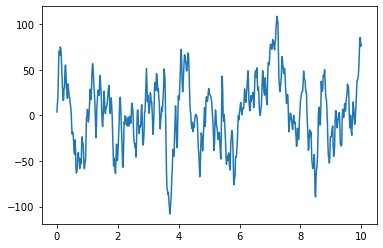

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered (dvariance)--------
X_train: shape of(1387, 28, 31)
X_test: shape of(1487, 28, 31)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


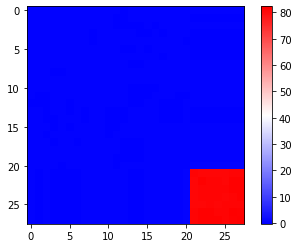

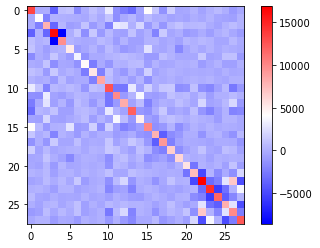

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

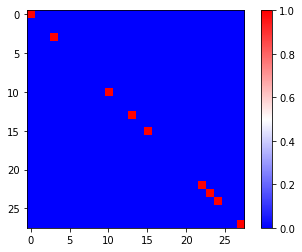

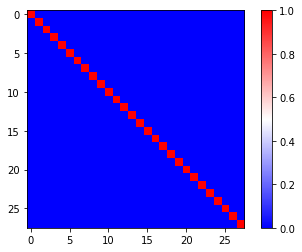

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

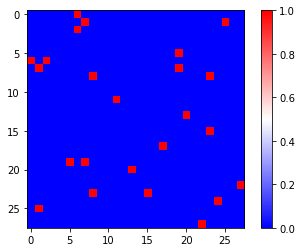

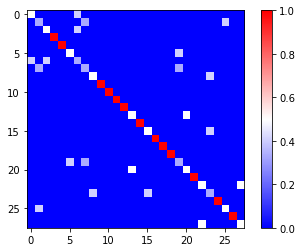

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

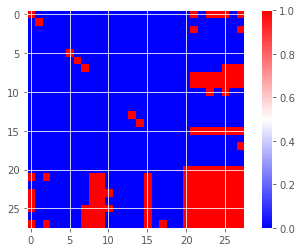

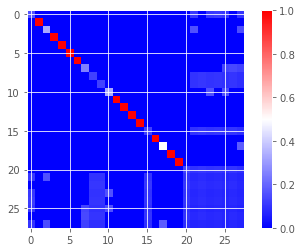

In [54]:
n = 8*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [64]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 1,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
RNNparametersGCN = {
    'hidden_dim' : 10,
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-3,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
RNNparametersGDE = {
    'hidden_dim' : 10,
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-3,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

In [ ]:
IM = Integrated_Model_RNN(GCNparameters, GDEparameters, RNNparametersGCN, RNNparametersGDE, dm, create_DAD(Araw))

  0%|          | 0/11 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 501.31793212890625   Valid loss: 500.63919067382815
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


 18%|█▊        | 2/11 [00:00<00:01,  6.18it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.06it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  6.07it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  6.18it/s]

 91%|█████████ | 10/11 [00:01<00:00,  6.16it/s]

100%|██████████| 11/11 [00:01<00:00,  6.15it/s]


Epoch: 1   Batch: 11 of size 128   Train loss: 497.5368957519531   Valid loss: 497.51580810546875
----------Training Ends-----------
----------Training RNN-----------
0.615 ----------saved-----------
0.651 ----------saved-----------
0.671 ----------saved-----------
0.684 ----------saved-----------
0.695 ----------saved-----------
0.704 ----------saved-----------
0.712 ----------saved-----------
0.718 ----------saved-----------
0.724 ----------saved-----------
0.73 ----------saved-----------
0.736 ----------saved-----------
0.74 ----------saved-----------
0.745 ----------saved-----------
0.75 ----------saved-----------
0.754 ----------saved-----------
0.758 ----------saved-----------
0.762 ----------saved-----------
0.766 ----------saved-----------
0.77 ----------saved-----------
0.773 ----------saved-----------
0.776 ----------saved-----------
0.78 ----------saved-----------
0.782 ----------saved-----------
0.784 ----------saved-----------
0.786 ----------saved-----------
0.787 -------

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.3645 F1 accuracy 0.569 Precision accuracy 0.679 Recall accuracy 0.49 AUC accuracy: 0.867
device set to cuda
threshold: 0.1  validation loss: 0.3645 F1 accuracy 0.56 Precision accuracy 0.674 Recall accuracy 0.479 AUC accuracy: 0.867
device set to cuda
threshold: 0.15  validation loss: 0.3645 F1 accuracy 0.563 Precision accuracy 0.692 Recall accuracy 0.474 AUC accuracy: 0.867
device set to cuda
threshold: 0.2  validation loss: 0.3645 F1 accuracy 0.573 Precision accuracy 0.724 Recall accuracy 0.474 AUC accuracy: 0.867
device set to cuda
threshold: 0.25  validation loss: 0.3645 F1 accuracy 0.58 Precision accuracy 0.748 Recall accuracy 0.474 AUC accuracy: 0.867
device set to cuda
threshold: 0.3  validation loss: 0.3645 F1 accuracy 0.58 Precision accuracy 0.748 Recall accuracy 0.474 AUC accuracy: 0.867
device set to cuda
threshold: 0.35  validation loss: 0.3645 F1 accuracy 0.58 Precision accuracy 0.748 Recall accuracy 0.474

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold: 0.2  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.25  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.3  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.35  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.4  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.45  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.5  validation loss: 0.4015 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.802
device set to cuda
threshold: 0.55  validation los

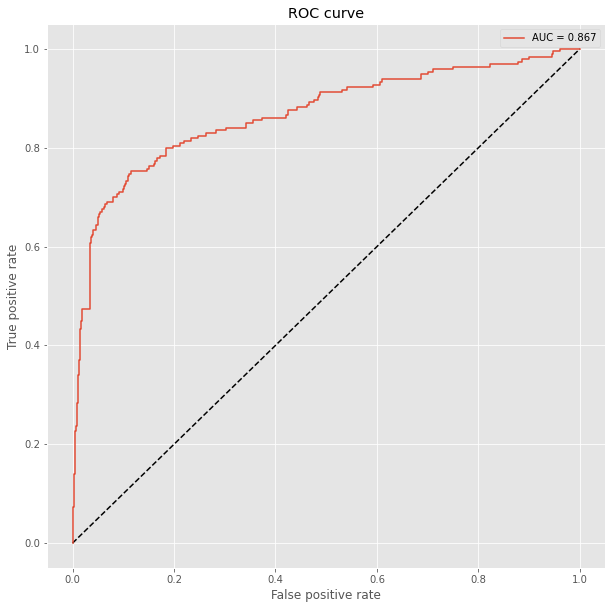

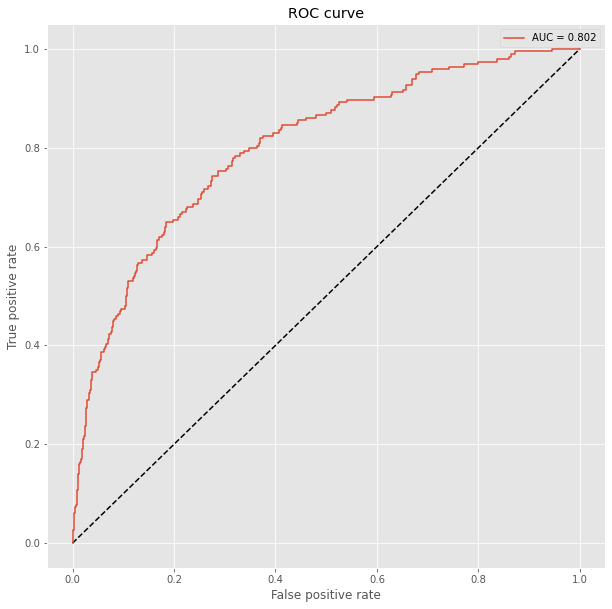

In [63]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')